# CdV system in python for LCEs and FTLEs
- implement rhs of CdV
- Use that and the trajectories form fortran to calculate
    - LCEs (t->infty)
    - FTLEs

In [2]:
import numpy as np
import cdv_utils
import matplotlib.pyplot as plt
import importlib
from lyapynov import ContinuousDS, DiscreteDS
from lyapynov import mLCE, LCE, CLV, ADJ

importlib.reload(cdv_utils)

<module 'cdv_utils' from '/home/schoelleh96/Nextcloud/AGPfahl/AGMeeting/20241119_PaperClub/code/code_deposit/cdv_utils.py'>

In [27]:
from cdv_utils import (load_d, build_df, compute_eof,
                       plot_density_heatmap, plot_scatter, fit_hmm,
                       analyze_regime_escape_times)

In [14]:
x1s = .95
x4s = -.76095
C = .1
beta = 1.25
gamma = .2
b = .5

m = np.array([1, 2])
alpha = 8*np.sqrt(2)*m**2*(b**2+m**2-1)/np.pi/(4*m**2-1)/(b**2+m**2)
beta = beta*b**2/(b**2+m**2)
delta = 64*np.sqrt(2)*(b**2-m**2+1)/15/np.pi/(b**2+m**2)
gamma_m = gamma*4*np.sqrt(2)*m**3*b/np.pi/(4*m**2-1)/(b**2+m**2)
gamma_m_star = gamma*4*np.sqrt(2)*m*b/np.pi/(4*m**2-1)
epsilon = 16*np.sqrt(2)/5/np.pi

# linear part of the operator
L = np.zeros((6, 6))
L[0, 0], L[2, 0] = -C, gamma_m_star[0]
L[1, 1], L[2, 1] = -C, beta[0]
L[0, 2], L[1, 2], L[2, 2] = -gamma_m[0], -beta[0], -C
L[3, 3], L[5, 3] = -C, gamma_m_star[1]
L[4, 4], L[5, 4] = -C, beta[1]
L[3, 5], L[4, 5], L[5, 5] = -gamma_m[1], -beta[1], -C

b = np.zeros((1, 6))
b[:, 0], b[:, 3] = C*x1s, C*x4s


def NL(x):

    Nx = np.zeros(x.shape)

    Nx[1] = -alpha[0]*x[0]*x[2] - delta[0]*x[3]*x[5]
    Nx[2] = alpha[0]*x[0]*x[1] + delta[0]*x[3]*x[4]
    Nx[3] = epsilon*(x[1]*x[5] - x[2]*x[4])
    Nx[4] = -alpha[1]*x[0]*x[5] - delta[1]*x[2]*x[3]
    Nx[5] = alpha[1]*x[0]*x[4] + delta[1]*x[3]*x[1]

    return Nx


def dynamics(x, t):

    dxdt = x @ L + NL(x) + b

    return dxdt[0]


def system_jacobian(x, t):
    J = np.copy(L)

    # Compute contributions to Jacobian from nonlinear terms
    J[1, 0] += -alpha[0] * x[2]
    J[1, 2] += -alpha[0] * x[0]
    J[1, 3] += -delta[0] * x[5]
    J[1, 5] += -delta[0] * x[3]

    J[2, 0] += alpha[0] * x[1]
    J[2, 1] += alpha[0] * x[0]
    J[2, 3] += delta[0] * x[4]
    J[2, 4] += delta[0] * x[3]

    J[3, 1] += epsilon * x[5]
    J[3, 2] += -epsilon * x[4]
    J[3, 4] += -epsilon * x[2]
    J[3, 5] += epsilon * x[1]

    J[4, 0] += -alpha[1] * x[5]
    J[4, 3] += -delta[1] * x[2]
    J[4, 2] += -delta[1] * x[3]
    J[4, 5] += -alpha[1] * x[0]

    J[5, 0] += alpha[1] * x[4]
    J[5, 3] += delta[1] * x[1]
    J[5, 1] += delta[1] * x[3]
    J[5, 4] += alpha[1] * x[0]

    return J

In [4]:
import math
params = [0.95, -0.76095, 0.1, 1.25, 0.2, 0.5]


def cdv(u, t):

    x1, x2, x3, x4, x5, x6 = u
    x1star, x4star, C, beta, gamma, b = params

    def alpha_m(m, b):
        return (8.*math.sqrt(2.)/math.pi)*(m*m/(4*m*m-1))*((b*b + m*m - 1)/(b*b+m*m))

    def beta_m(m, b):
        return beta*b*b/(b*b+m*m)

    def gamma_m(m, b):
        return gamma*(4*m*m*m/(4*m*m-1))*(math.sqrt(2)*b/(math.pi*(b*b + m*m)))

    def gamma_m_tld(m, b):
        return gamma*(4*m/(4*m*m-1))*(math.sqrt(2)*b/math.pi)

    def delta(m, b):
        return (64.*math.sqrt(2.)/(15.*math.pi))*((b*b - m*m+1)/(b*b+m*m))

    # epsilon = 16.*math.sqrt(2)/(5*math.pi)
    epsilon = 1.44050610585137

    x1dot = gamma_m_tld(1, b)*x3 - C*(x1 - x1star)
    x4dot = gamma_m_tld(2, b)*x6 - C*(x4 - x4star) + epsilon*(x2*x6 - x3*x5)

    x2dot = -(alpha_m(1, b)*x1 - beta_m(1, b))*x3 - C*x2 - delta(1, b)*x4*x6
    x5dot = -(alpha_m(2, b)*x1 - beta_m(2, b))*x6 - C*x5 - delta(2, b)*x4*x3

    x3dot = (alpha_m(1, b)*x1 - beta_m(1, b))*x2 - \
        gamma_m(1, b)*x1 - C*x3 + delta(1, b)*x4*x5
    x6dot = (alpha_m(2, b)*x1 - beta_m(2, b))*x5 - \
        gamma_m(2, b)*x4 - C*x6 + delta(2, b)*x4*x2

    return np.array([x1dot, x2dot, x3dot, x4dot, x5dot, x6dot])


def cdvjac(u, t):

    x1, x2, x3, x4, x5, x6 = u
    x1star, x4star, C, beta, gamma, b = params

    def alpha_m(m, b):
        return (8.*math.sqrt(2.)/math.pi)*(m*m/(4*m*m-1))*((b*b + m*m - 1)/(b*b+m*m))

    def beta_m(m, b):
        return beta*b*b/(b*b+m*m)

    def gamma_m(m, b):
        return gamma*(4*m*m*m/(4*m*m-1))*(math.sqrt(2)*b/(math.pi*(b*b + m*m)))

    def gamma_m_tld(m, b):
        return gamma*(4*m/(4*m*m-1))*(math.sqrt(2)*b/math.pi)

    def delta(m, b):
        return (64.*math.sqrt(2.)/(15.*math.pi))*((b*b - m*m+1)/(b*b+m*m))

    # epsilon = 16.*math.sqrt(2)/(5*math.pi)
    epsilon = 1.44050610585137

    dx1dot = np.array([-C, 0., gamma_m_tld(1, b), 0., 0., 0.])
    dx2dot = np.array([-alpha_m(1, b)*x3, -C, -alpha_m(1, b)
                      * x1 + beta_m(1, b), -delta(1, b)*x6, 0., -delta(1, b)*x4])
    dx3dot = np.array([alpha_m(1, b)*x2-gamma_m(1, b), alpha_m(1, b)
                      * x1 - beta_m(1, b), -C, delta(1, b)*x5, delta(1, b)*x4, 0.])
    dx4dot = np.array([0., epsilon*x6, -epsilon*x5, -C, -
                      epsilon*x3, gamma_m_tld(2, b)+epsilon*x2])
    dx5dot = np.array([-alpha_m(2, b)*x6, 0., -delta(2, b) *
                      x4, -delta(2, b)*x3, -C, -alpha_m(2, b)*x1 + beta_m(2, b)])
    dx6dot = np.array([alpha_m(2, b)*x5, delta(2, b)*x4, 0, -gamma_m(2,
                      b) + delta(2, b)*x2, alpha_m(2, b)*x1 - beta_m(2, b), -C])

    return np.array([dx1dot, dx2dot, dx3dot, dx4dot, dx5dot, dx6dot])

# Verfiy that the above is equivalent to fortran

In [8]:
dims = 6
sample_num = 200000
state_vector = load_d('./cdv_model/dataOro20.bin', dims, sample_num)

Sample 0 of 1000
Sample 1 of 1000
Sample 2 of 1000
Sample 3 of 1000
Sample 4 of 1000
Sample 5 of 1000
Sample 6 of 1000
Sample 7 of 1000
Sample 8 of 1000
Sample 9 of 1000
Sample 10 of 1000
Sample 11 of 1000
Sample 12 of 1000
Sample 13 of 1000
Sample 14 of 1000
Sample 15 of 1000
Sample 16 of 1000
Sample 17 of 1000
Sample 18 of 1000
Sample 19 of 1000
Sample 20 of 1000
Sample 21 of 1000
Sample 22 of 1000
Sample 23 of 1000
Sample 24 of 1000
Sample 25 of 1000
Sample 26 of 1000
Sample 27 of 1000
Sample 28 of 1000
Sample 29 of 1000
Sample 30 of 1000
Sample 31 of 1000
Sample 32 of 1000
Sample 33 of 1000
Sample 34 of 1000
Sample 35 of 1000
Sample 36 of 1000
Sample 37 of 1000
Sample 38 of 1000
Sample 39 of 1000
Sample 40 of 1000
Sample 41 of 1000
Sample 42 of 1000
Sample 43 of 1000
Sample 44 of 1000
Sample 45 of 1000
Sample 46 of 1000
Sample 47 of 1000
Sample 48 of 1000
Sample 49 of 1000
Sample 50 of 1000
Sample 51 of 1000
Sample 52 of 1000
Sample 53 of 1000
Sample 54 of 1000
Sample 55 of 1000
Sa

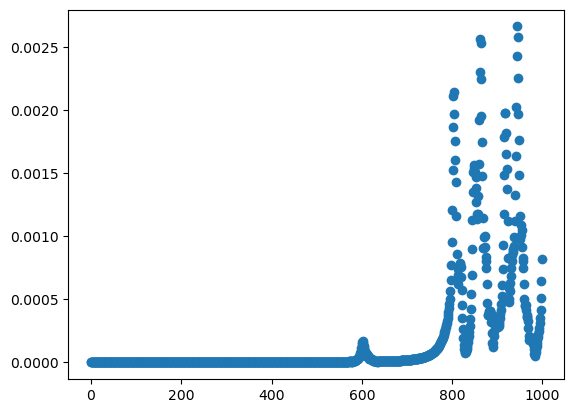

In [51]:
x0 = state_vector[0, :]
dt = 2e-4
sample_t = 1
t_f = 1000
x = np.zeros((int(t_f/sample_t), dims))
for j in range(int(t_f/dt)):
    if j % (sample_t/dt) == 0:
        print(f'Sample {int(j // (sample_t / dt))} of {int(t_f/sample_t)}')
        x[int(j // (sample_t / dt)), :] = x0
    k1 = dt*cdv(x0, 0)

    k2 = dt * cdv(x0 + 0.5 * k1, 0)
    x0 = x0+k2

plt.plot(range(int(t_f/sample_t)), np.linalg.norm(
    x - state_vector[:int(t_f/sample_t), :], axis=1),
    'o')

# Functions for LE calculation

In [5]:
import scipy


def F_all(eom, jac, u, M, params):
    ''' solves system. u is the state vector composed
        by the variables. J is the Jacobian and M are the
        Gram-Schmidt Lyapunov vectors'''

    dqdt = eom(u, params)
    J = jac(u, params)
    dMdt = np.dot(J, M)

    return dqdt, dMdt


def qr_factorization(A):
    m, n = A.shape
    Q = np.zeros((m, n))
    R = np.zeros((n, n))

    for j in range(n):
        v = A[:, j].copy()

        for i in range(j):
            q = Q[:, i]
            R[i, j] = q.dot(v)
            v = v - R[i, j] * q

        norm = np.linalg.norm(v)
        Q[:, j] = v / norm
        R[j, j] = norm
    return Q, R


def RK4var(f, eom, jac, x, dt, pf, mat):

    K1, M1 = f(eom, jac, x, mat, pf)
    K2, M2 = f(eom, jac, x + dt*K1/2.0, mat + dt*M1/2.0, pf)
    K3, M3 = f(eom, jac, x + dt*K2/2.0, mat + dt*M2/2.0, pf)
    K4, M4 = f(eom, jac, x + dt*K3, mat + dt*M3, pf)

    A = np.array(dt * (K1/2.0 + K2 + K3 + K4/2.0) / 3.0)
    B = np.array(dt * (M1/2.0 + M2 + M3 + M4/2.0) / 3.0)
    return A, B


def solve_ode_LEs(eom, jac, N, Ntherm, dt, u0, params, norm_time=1):
    """
    Solves the ODEs for N time steps starting from u0.
    Additionally computes the full Lyapunov spectrum.

    Args:
        eom: function(x, params) returning dx/dt
        jac: function(x, params) returning Jacobian matrix
        N: total number of timesteps
        Ntherm: number of timesteps to discard as transient
        dt: timestep size
        u0: initial condition (1D array)
        params: parameters passed to eom and jac
        norm_time: interval (in steps) between QR re-orthonormalizations

    Returns:
        Xt: array of shape (N+1, dim), state trajectory
        LEs: array of shape (dim,), estimated Lyapunov exponents
    """
    # State dimension
    dim = u0.size

    # Precompute time arrays
    T = np.arange(N+1) * dt
    N_test = N - Ntherm
    N_test_norm = N_test // norm_time

    # Allocate storage
    Xt = np.empty((N+1, dim))
    Xt[0] = u0.copy()
    LE = np.zeros((N_test_norm, dim))
    FTLE = np.zeros((N_test_norm, dim))

    # Initialize random orthonormal tangent vectors
    U = scipy.linalg.orth(np.random.rand(dim, dim))
    Q, R = qr_factorization(U)
    U = Q[:, :dim]

    indx = 0
    x = u0.copy()
    for i in range(1, N+1):
        # One variational RK4 step
        dx, dU = RK4var(F_all, eom, jac, x, dt, params, U)
        x = x + dx
        U = U + dU

        # QR re-orthonormalization
        if i % norm_time == 0:
            Q, R = qr_factorization(U)
            U = Q[:, :dim]
            if i > Ntherm:
                LE[indx] = np.abs(np.diag(R))
                FTLE[indx] = (1./dt)*np.log(LE[indx])

                indx += 1
        Xt[i] = x

    # Time intervals for diagnostics
    Ttest = (np.arange(1, N_test_norm+1) * norm_time * dt)

    # Compute Lyapunov exponents
    # mean of log stretches over time
    LEs = np.cumsum(np.log(LE[:]), axis=0) / np.tile(Ttest[:], (dim, 1)).T

    return Xt, LEs

In [28]:
def lorenz_rhs(x, t, sigma=10, rho=28, beta=8/3):
    return np.array([sigma*(x[1]-x[0]), x[0]*(rho-x[2]) - x[1], x[0]*x[1] - beta*x[2]])


def lorenz_jac(x, t, sigma=10, rho=28, beta=8/3):
    return np.array([[-sigma, sigma, 0],
                     [rho - x[2], -1, -x[0]],
                     [x[1], x[0], -beta]])


x0 = np.array([1.5, -1.5, 20.])
t0 = 0.
dt = 1e-2

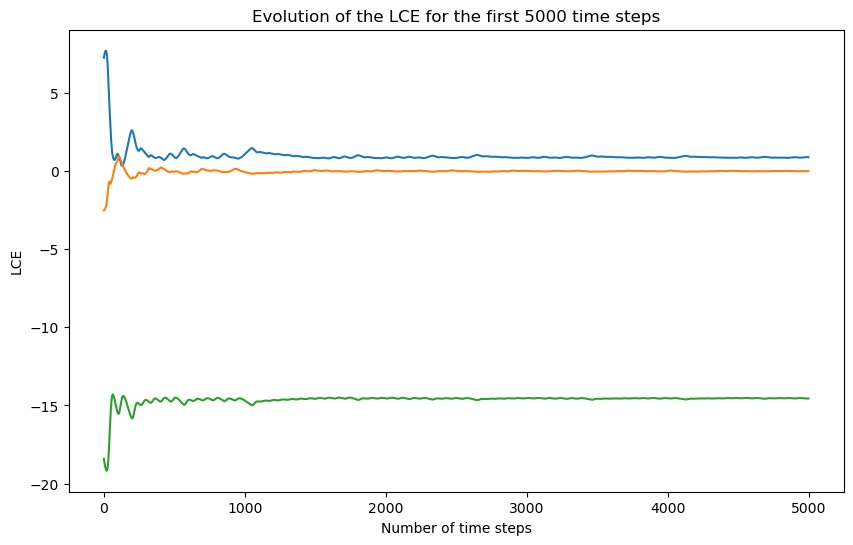

LCE: [ 9.07992586e-01  5.88099470e-05 -1.45746156e+01]


In [33]:
Xt, LEs = solve_ode_LEs(lorenz_rhs, lorenz_jac, 10**6, 10**3, dt, x0, 1)
plt.figure(figsize=(10, 6))
plt.plot(LEs[:5000])
plt.xlabel("Number of time steps")
plt.ylabel("LCE")
plt.title("Evolution of the LCE for the first 5000 time steps")
plt.show()
print(f"LCE: {LEs[-1]}")  # Print the last LCE value

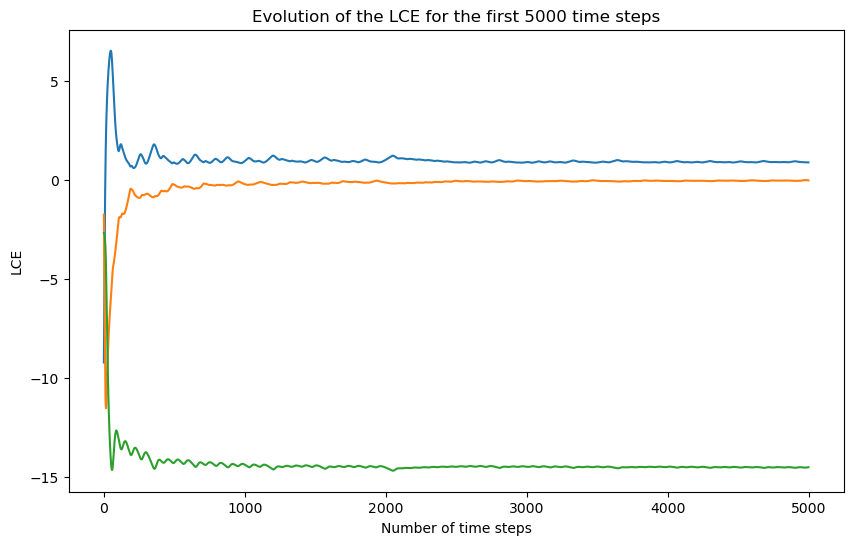

LCE: [ 9.05774268e-01 -1.81082249e-04 -1.45721550e+01]


In [34]:

Lorenz63 = ContinuousDS(x0, t0, lorenz_rhs, lorenz_jac, dt)
Lorenz_LCE, history = LCE(Lorenz63, 3, 0, 10**6, True)
plt.figure(figsize=(10, 6))
plt.plot(history[:5000])
plt.xlabel("Number of time steps")
plt.ylabel("LCE")
plt.title("Evolution of the LCE for the first 5000 time steps")
plt.show()
print(f"LCE: {Lorenz_LCE}")

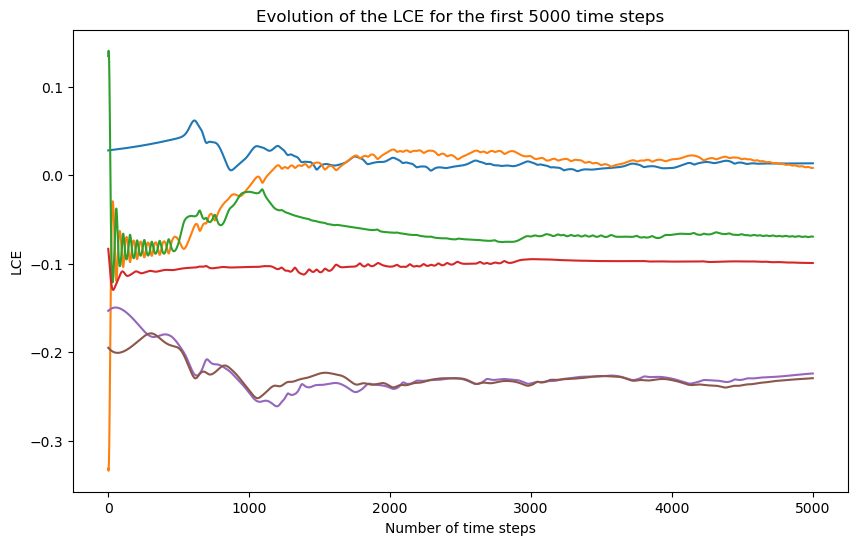

LCE: [ 0.02057721 -0.00042733 -0.07667892 -0.10122058 -0.2172523  -0.22499801]


In [40]:
Xt, LEs = solve_ode_LEs(cdv, cdvjac, 10**5, 10**3, 0.1,
                        np.array([0.74386288,  0.19322051, -0.34494619, -
                                  0.3342756, -0.11471851, 0.34287484]), 1)
plt.figure(figsize=(10, 6))
plt.plot(LEs[:5000])
plt.xlabel("Number of time steps")
plt.ylabel("LCE")
plt.title("Evolution of the LCE for the first 5000 time steps")
plt.show()
print(f"LCE: {LEs[-1]}")  # Print the last LCE value

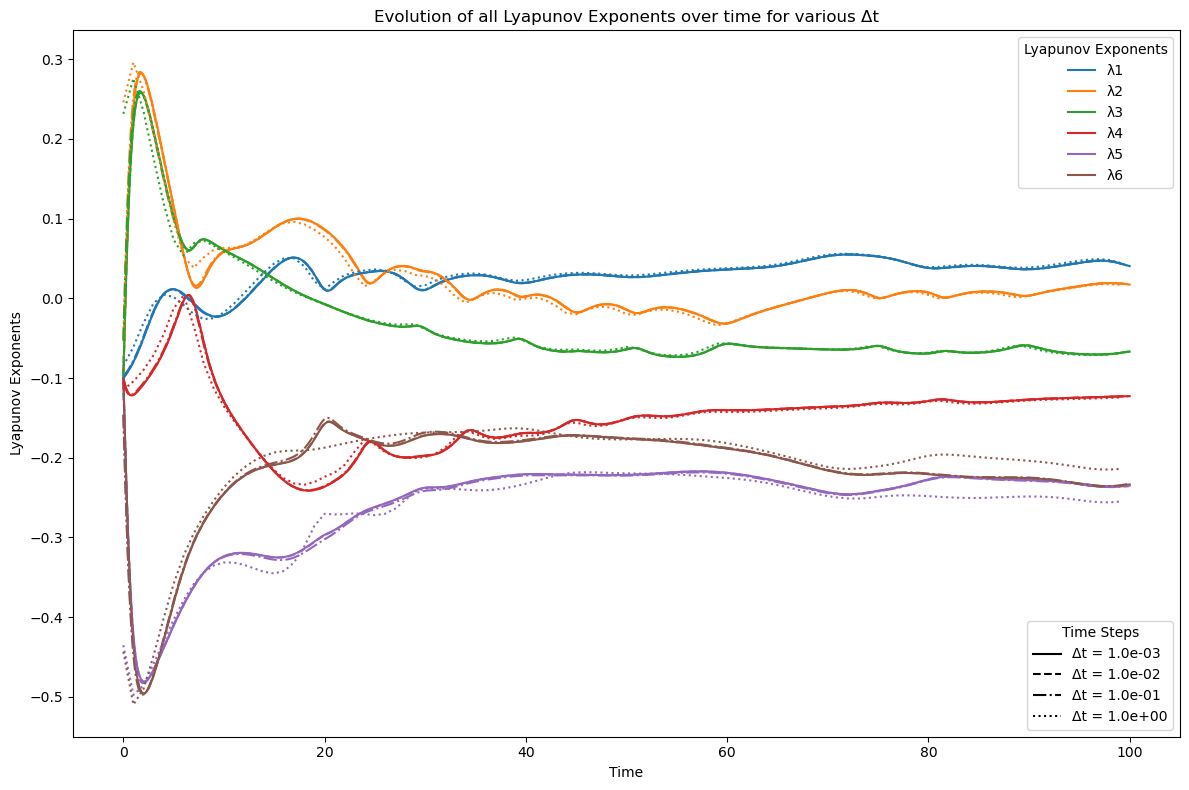

In [42]:
from matplotlib.lines import Line2D
x0 = state_vector[0, :]
dts = np.logspace(-3, 0, 4)
t_f = 100
t0 = 0.
linestyles = ['-', '--', '-.', ':']

# Dictionary to store histories for each dt
histories = {}
times_dict = {}

plt.figure(figsize=(12, 8))

for i, (dt, ls) in enumerate(zip(dts, linestyles)):
    # build and iterate the continuous dynamical system
    CdV = ContinuousDS(x0, t0, cdv, cdvjac, dt)
    CdV_LCE, history = LCE(
        CdV,
        p=6,
        n_forward=0,
        n_compute=int(t_f / dt),
        keep=True
    )

    # Store history and times for this dt
    histories[dt] = history
    times = np.arange(len(history)) * dt
    times_dict[dt] = times

    # plot all 6 LCEs vs. time with different colors for each exponent
    for j in range(6):  # 6 Lyapunov exponents
        # Label for Lyapunov exponents (only for first dt)
        le_label = f'λ{j+1}' if i == 0 else ""
        plt.plot(times, history[:, j], linestyle=ls,
                 color=f'C{j}', label=le_label)

# Create custom legend entries for dt values
dt_legend_elements = [Line2D([0], [0], color='black', linestyle=ls,
                             label=f'Δt = {dt:.1e}')
                      for dt, ls in zip(dts, linestyles)]

# Create combined legend
le_legend = plt.legend(loc='upper right', title='Lyapunov Exponents')
dt_legend = plt.legend(handles=dt_legend_elements,
                       loc='lower right', title='Time Steps')
plt.gca().add_artist(le_legend)  # Add back the first legend

# final plot tweaks
plt.xlabel("Time")
plt.ylabel("Lyapunov Exponents")
plt.title("Evolution of all Lyapunov Exponents over time for various Δt")
plt.tight_layout()
plt.show()

**It seems like dt = 1e-1 is enough, so we use that to simulate asymptotics**

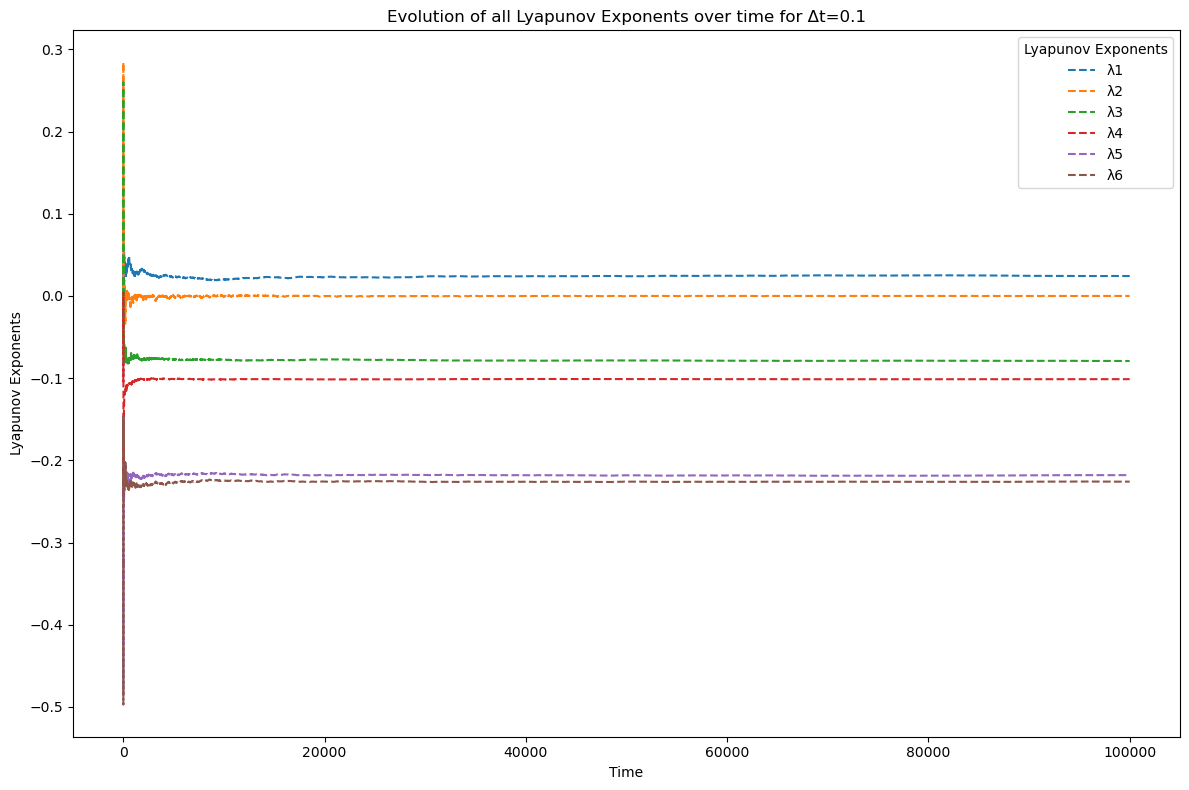

LCE: [ 2.42296851e-02 -1.31649739e-05 -7.91507243e-02 -1.01229869e-01
 -2.17953884e-01 -2.25881982e-01]


In [16]:
x0 = state_vector[0, :]
t_f = 1e5
t0 = 0.
dt = 1e-1
plt.figure(figsize=(12, 8))

CdV = ContinuousDS(x0, t0, cdv, cdvjac, dt)
CdV_LCE, history = LCE(
    CdV,
    p=6,
    n_forward=0,
    n_compute=int(t_f / dt),
    keep=True
)

times = np.arange(len(history)) * dt

for j in range(6):  # 6 Lyapunov exponents
    le_label = f'λ{j+1}'
    plt.plot(times, history[:, j], linestyle='--',
             color=f'C{j}', label=le_label)

plt.legend(loc='upper right', title='Lyapunov Exponents')

# final plot tweaks
plt.xlabel("Time")
plt.ylabel("Lyapunov Exponents")
plt.title("Evolution of all Lyapunov Exponents over time for Δt=0.1")
plt.tight_layout()
plt.show()

print(f"LCE: {CdV_LCE}")

In [17]:
def reconstruct_logs(history, dt):
    """
    history: (n_steps, p) array where
      history[k,j] = (1/((k+1)*dt)) * sum_{m=0}^k ell_{m+1}^{(j)}
    returns logs: (n_steps, p) array of ell_k^{(j)}
    """
    n_steps, p = history.shape
    # build k and k-1 as column vectors
    k = np.arange(1, n_steps+1)[:, None]      # shape (n_steps,1)
    km1 = (k - 1)
    # history shifted by one (with a zero‐row at the top)
    hist_prev = np.vstack([np.zeros((1, p)), history[:-1]])
    # vectorized inversion of h_k = (1/(k*dt)) sum ell  =>  ell_k = (k*h_k - (k-1)*h_{k-1})*dt
    logs = (k*history - km1*hist_prev) * dt
    return logs


def compute_ftle_vectorized(logs, dt, window):
    """
    logs:   (n_steps, p) array of instantaneous log‐stretchings ell_k^{(j)}
    window: integer N  (number of steps in the FTLE window)
    returns:
      ftles: (n_steps, p) array, where
        ftles[k,j] = (1/(window*dt)) * sum_{m=k-window+1}^k logs[m,j],
      with NaN for k<window-1
    """
    n_steps, p = logs.shape
    # prefix‐sum of logs along time:
    csum = np.vstack([np.zeros((1, p)), np.cumsum(logs, axis=0)])
    # pairwise differences:  S[k] = csum[k] - csum[k-window]
    # we want S at k=window...n_steps
    S = csum[window:] - csum[:-window]   # shape = (n_steps-window+1, p)
    # allocate output
    ftles = np.empty_like(logs)
    ftles[:window-1] = np.nan
    ftles[window-1:] = S / (window * dt)
    return ftles


logs = reconstruct_logs(history, dt)

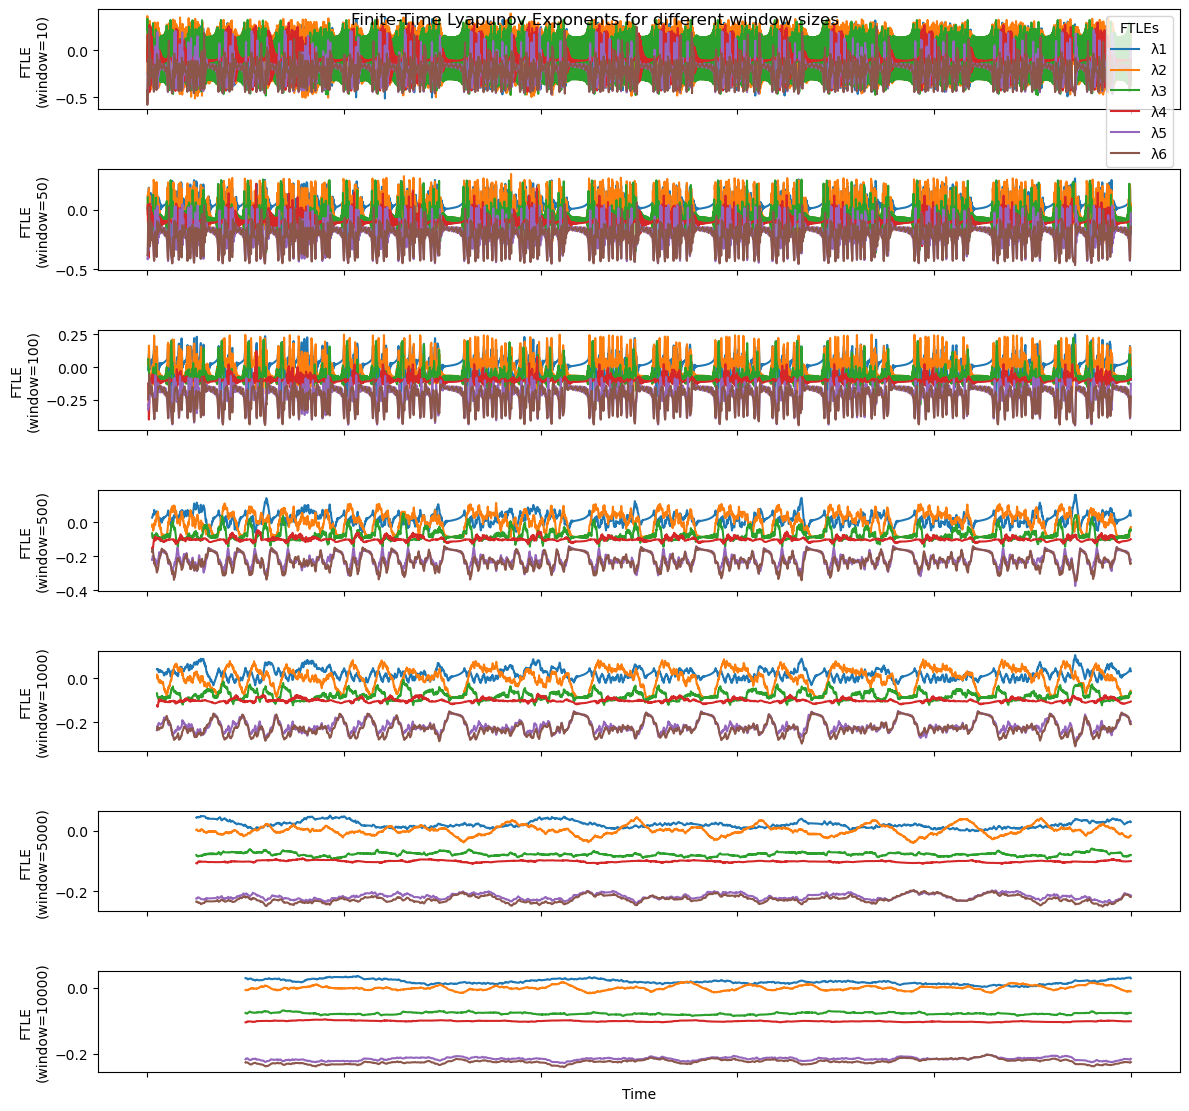

In [40]:
t_max = int(1e5)
window_sizes = [10, 50, 100, 500, 1000, 5000, 10000]
ftle_dict = {w: compute_ftle_vectorized(
    logs, dt, window=w) for w in window_sizes}
colors = [f'C{j}' for j in range(CdV_LCE.shape[0])]

fig, axes = plt.subplots(len(window_sizes), 1, figsize=(12, 12), sharex=True)

for idx, w in enumerate(window_sizes):
    ax = axes[idx]
    ftle = ftle_dict[w]
    for j in range(ftle.shape[1]):
        label = f'λ{j+1}' if idx == 0 else None
        ax.plot(times[:t_max], ftle[:t_max, j],
                color=colors[j], linestyle='-', label=label)
    ax.set_ylabel(f"FTLE\n(window={w})")
    if idx == 0:
        ax.legend(loc='upper right', title='FTLEs')
    if idx < len(window_sizes) - 1:
        ax.set_xlabel("")
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("Time")

fig.suptitle(
    "Finite-Time Lyapunov Exponents for different window sizes", y=0.92)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [19]:
state_LCE = CdV.forward(n_steps=int(t_f / dt)-1, keep_traj=True)
state_LCE.shape

(1000000, 6)

In [20]:
df = build_df(state_LCE, dims)
results = compute_eof(df, n_modes=6)
scores_df = results['scores_df']
scores_df["ftle_1000_max"] = np.max(ftle_dict[1000], axis=1)

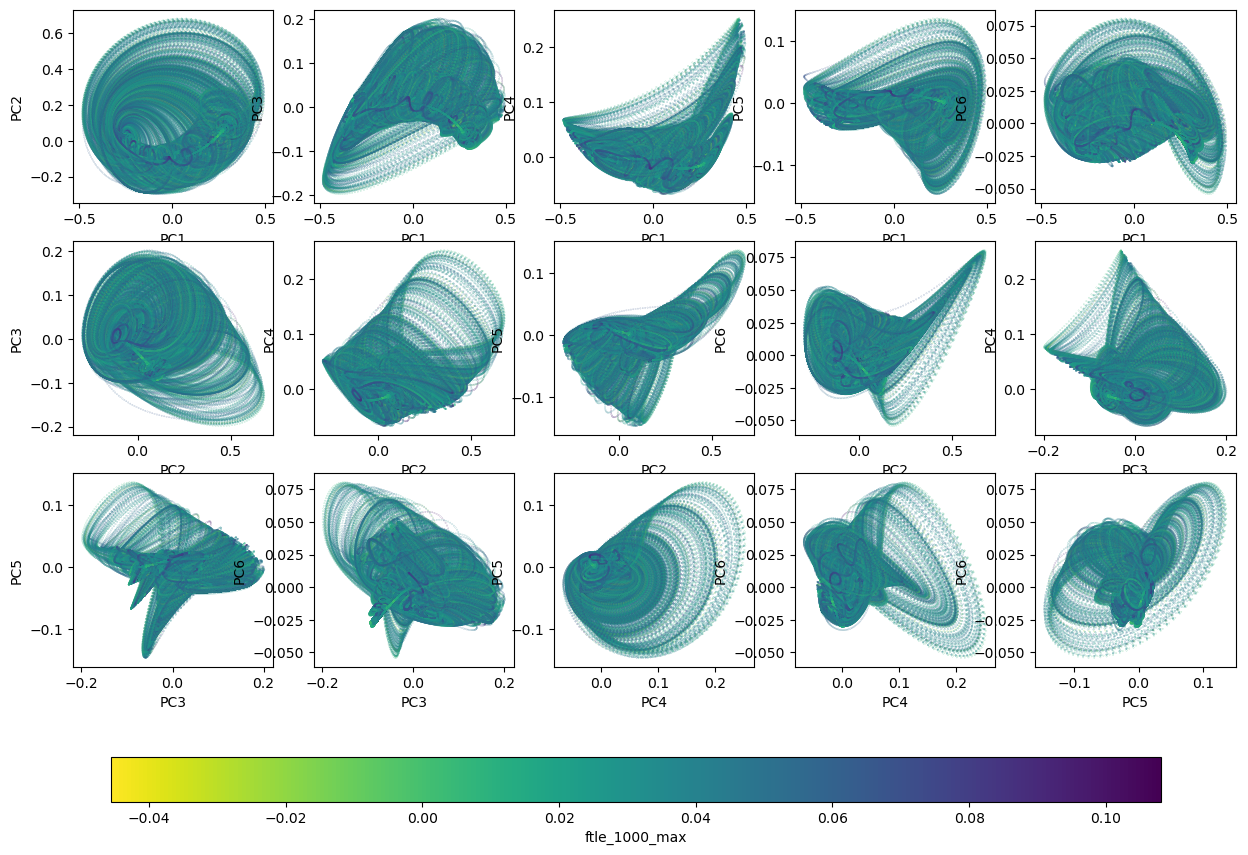

In [21]:
figs, axes = plot_scatter(scores_df, "ftle_1000_max")

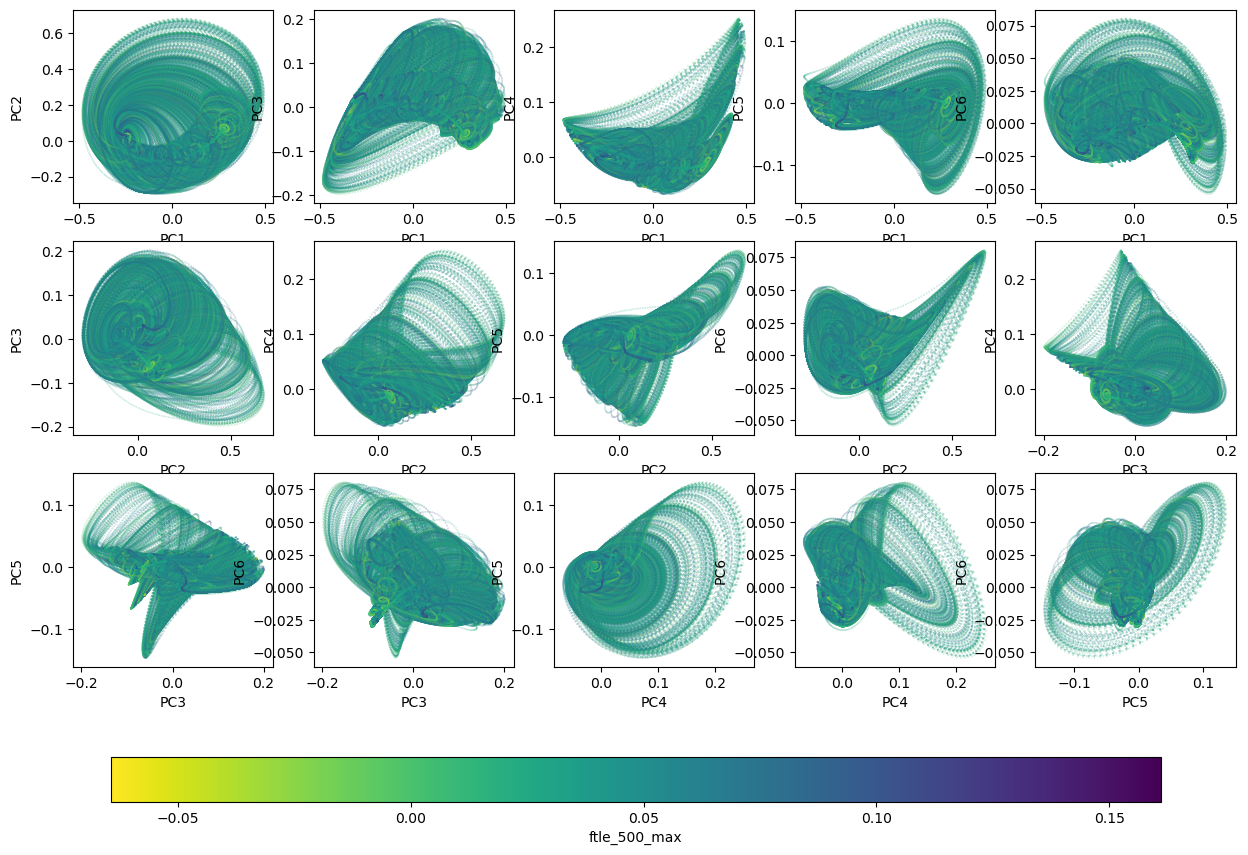

In [22]:
scores_df["ftle_500_max"] = np.max(ftle_dict[500], axis=1)
figs, axes = plot_scatter(scores_df, "ftle_500_max")

# Compare HMM state with maximum FTLE

In [25]:
fixed = np.array([
    [0.7285286,   0.15657308, -0.36810966, -0.32854071, -0.08004622, 0.34314342],
    [0.94484848, 0.10714876, -0.00858286, -0.71094887, -0.17206714, 0.03996197]
])
inits = np.r_[fixed, [(fixed[0] + fixed[1]) / 2]]
state_centers, states_sd, states = fit_hmm(
    state_LCE, 3, initial_centers=inits)

Transition Matrix:
Shape: (3, 3)
State 1: [0.9931 0.0051 0.0018]
State 2: [0.0071 0.9929 0.0000]
State 3: [0.0004 0.0021 0.9976]



Escape Time Statistics:
 state  n_episodes  mean_escape_time  median_escape_time  std_escape_time  min_escape_time  max_escape_time  total_time_in_state
     3         679        410.011782               161.0       524.113466              9.0           2207.0             278398.0
     2        2450        141.843673               175.0        79.305838             12.0            302.0             347517.0
     1        2536        147.509858                91.5       105.123451              8.0            337.0             374085.0

Regime 3 Analysis:
Number of episodes: 679
Mean escape time: 410.012
Median escape time: 161.000
Std escape time: 524.113

Points in regime 3: 278398
Escape times range: 1.000 to 2207.000

Regime 2 Analysis:
Number of episodes: 2450
Mean escape time: 141.844
Median escape time: 175.000
Std escape time: 79.306

Points in regime 2: 347517
Escape times range: 1.000 to 302.000

Regime 1 Analysis:
Number of episodes: 2536
Mean escape time: 147.510
Median escap

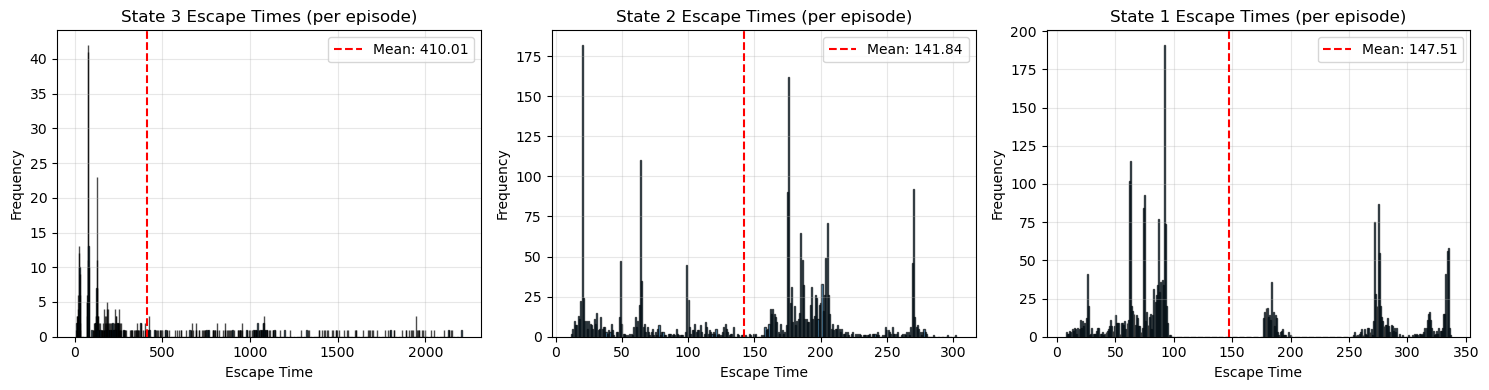

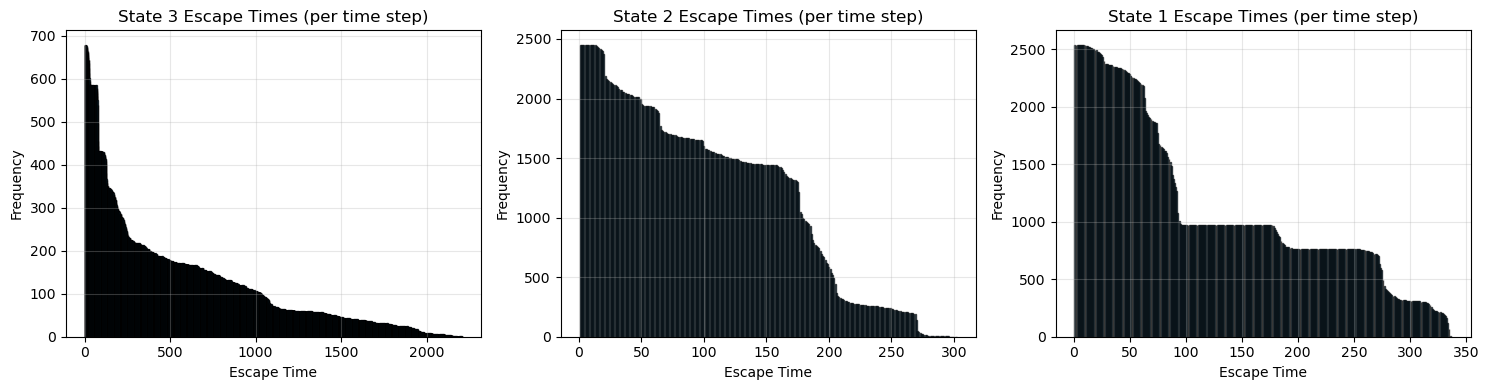

In [28]:
results = analyze_regime_escape_times(states, dt=1.0)

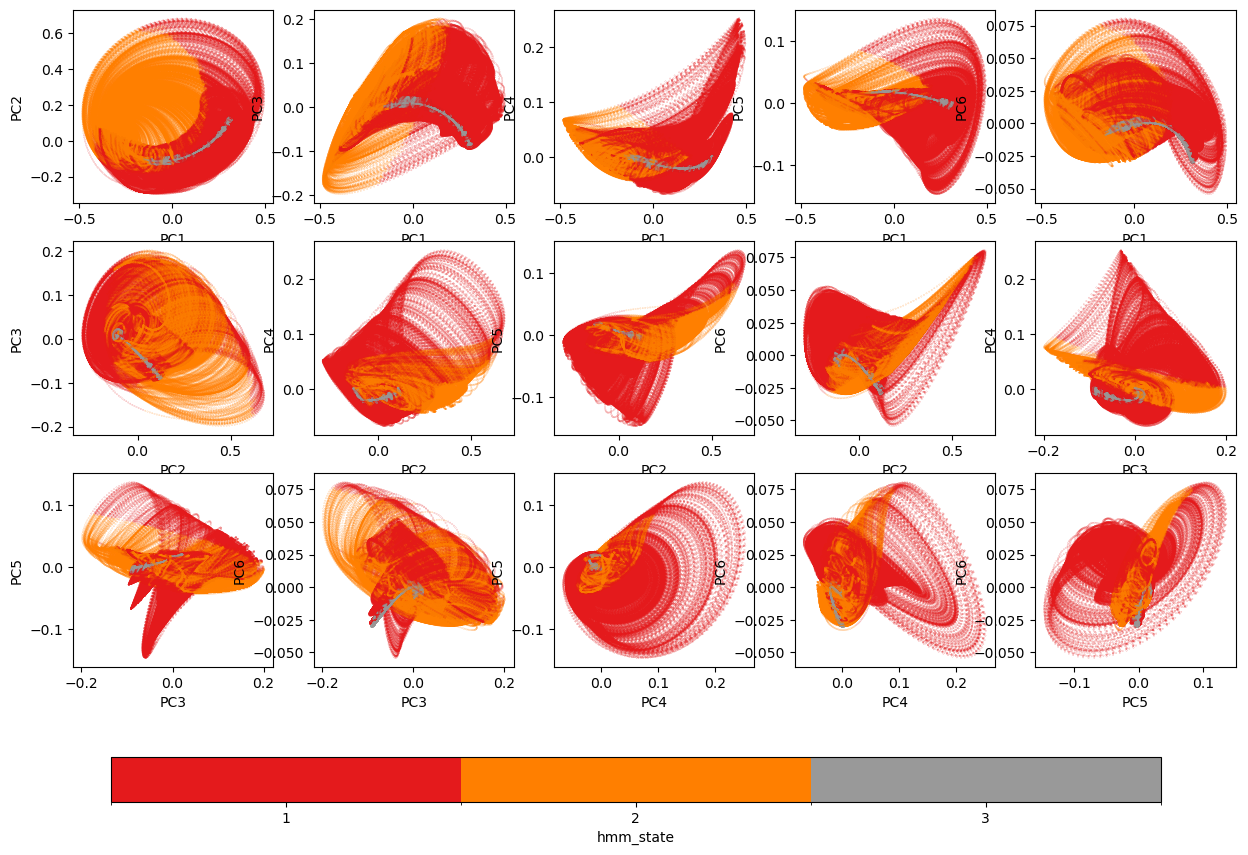

In [29]:
df = build_df(state_LCE, dims)
results = compute_eof(df, n_modes=6)
scores_df = results['scores_df']
scores_df["hmm_state"] = states
figs, axes = plot_scatter(scores_df, "hmm_state",
                          cmap="Set1", categorical=True)

In [6]:
import pickle

# List of variable names that took long to generate
long_vars = [
    'state_LCE', 'history', 'CdV_LCE', 'logs', 'ftle_dict',
    'state_centers', 'states_sd', 'states'
]

In [ ]:


# Save each variable to a separate pickle file
for var in long_vars:
    with open(f"FTLE_{var}.pkl", "wb") as f:
        pickle.dump(globals()[var], f)

In [7]:

# Dictionary to hold loaded variables
loaded_data = {}

# Load each variable
for var in long_vars:
    with open(f"FTLE_{var}.pkl", "rb") as f:
        loaded_data[var] = pickle.load(f)

ftle_dict = loaded_data['ftle_dict']
states = loaded_data['states']
window_sizes = [10, 50, 100, 500, 1000]

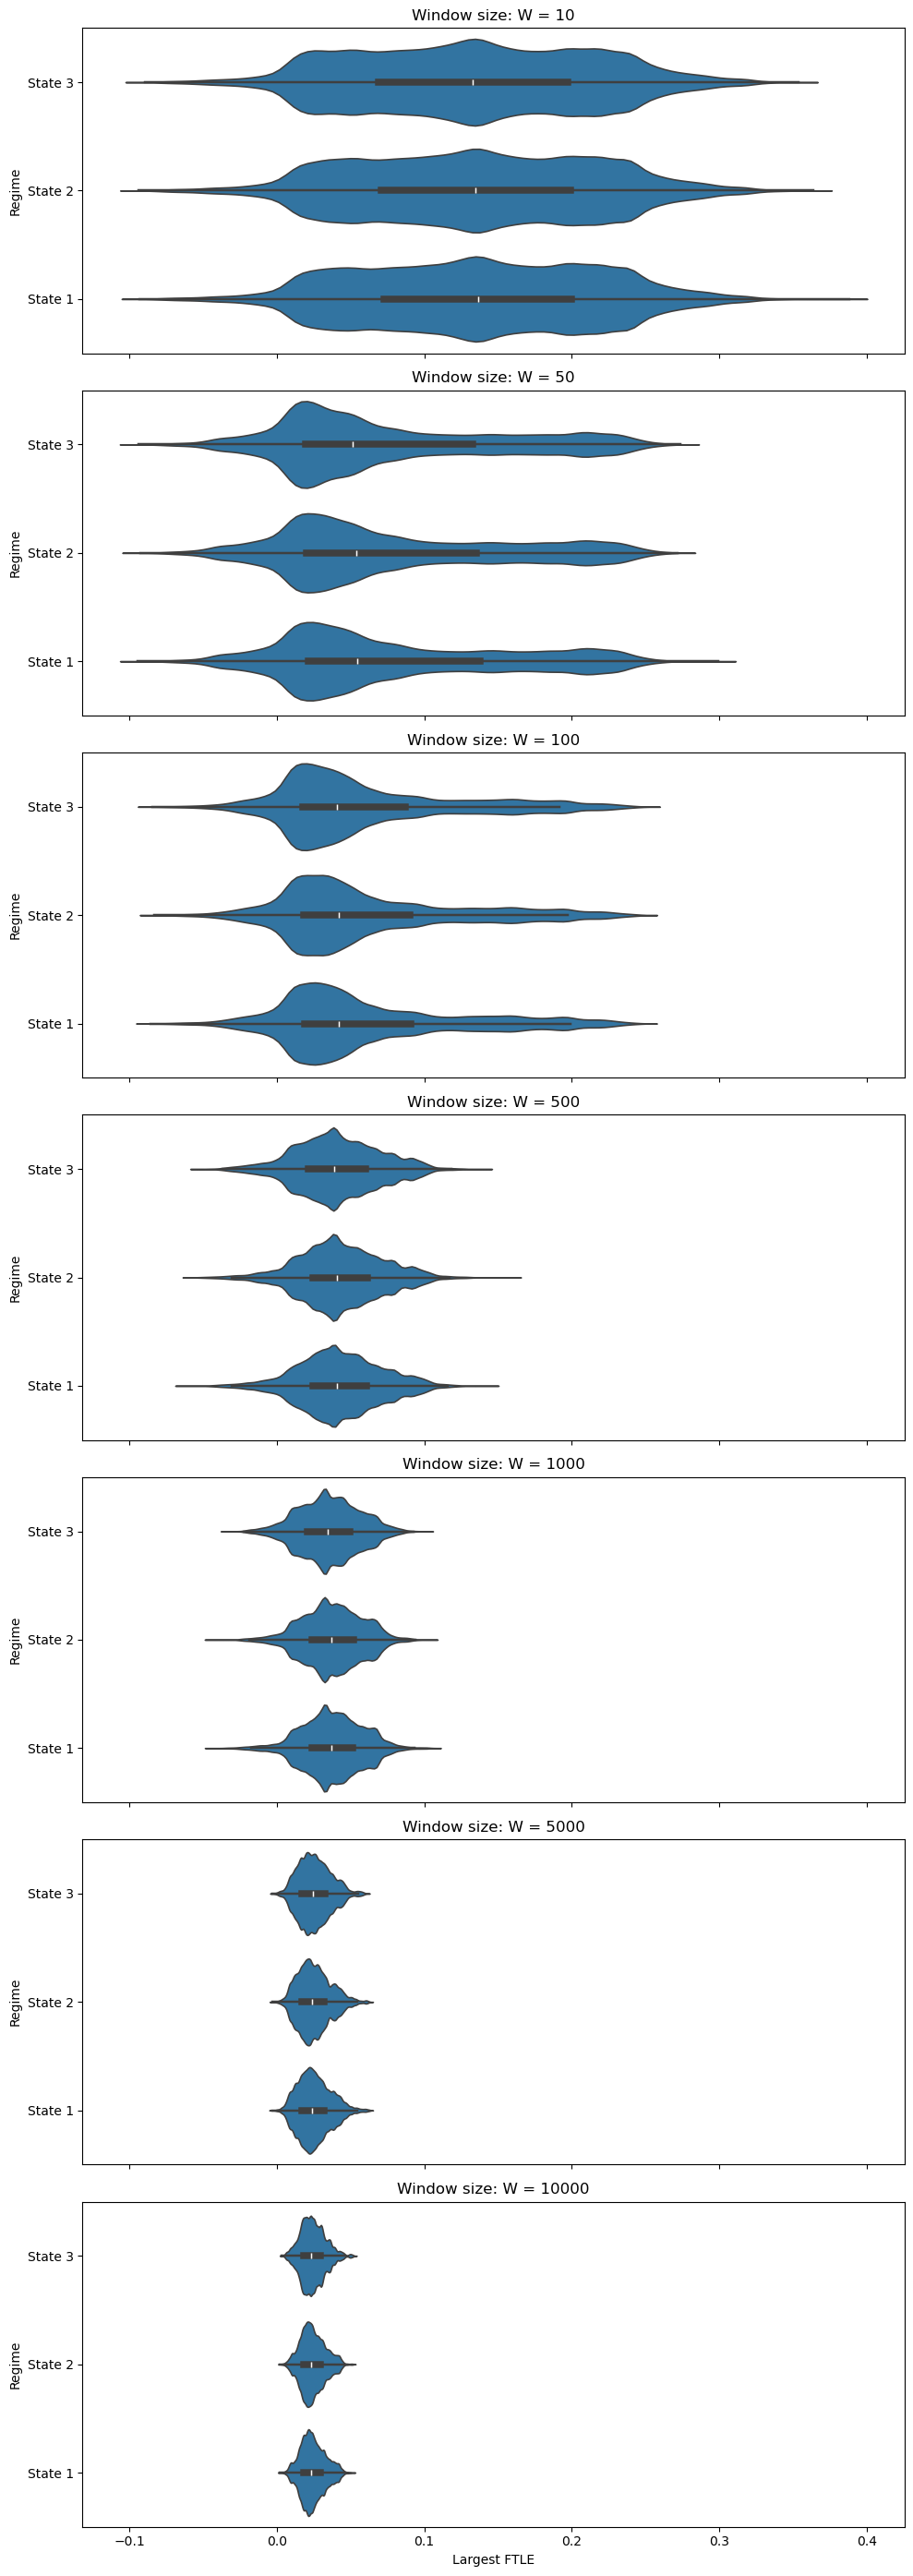

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Compute max FTLE per window
max_ftle = {
    w: np.max(arr, axis=1)
    for w, arr in ftle_dict.items()
}

# 2) Reshape into long-form DataFrame for Seaborn
records = []
for w, ftle_vals in max_ftle.items():
    for val, state in zip(ftle_vals, states):
        records.append({
            'FTLE': val,
            'Regime': f'State {state}',
            'Window': f'W = {w}'
        })

df = pd.DataFrame(records)

# 3) Set up subplots: one violin plot per window size
unique_windows = df['Window'].unique()
fig, axes = plt.subplots(
    nrows=len(unique_windows),
    ncols=1,
    figsize=(10, 4 * len(unique_windows)),
    sharex=True
)

# 4) Plot violin plots
for ax, window in zip(axes, unique_windows):
    sns.violinplot(
        data=df[df['Window'] == window],
        x='FTLE',
        y='Regime',
        ax=ax,
        inner='box',       # show median, IQR, and whiskers
        linewidth=1.2
    )
    ax.set_title(f"Window size: {window}")
    ax.set_ylabel("Regime")

# 5) Final touches
axes[-1].set_xlabel("Largest FTLE")
fig.tight_layout()
plt.show()